In [2]:
import os
import numpy as np
import pandas as pd

from astropy import units as u
from astropy.table import Table, Column, MaskedColumn
from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord, Distance, GCRS, CartesianRepresentation, match_coordinates_sky
from astropy.wcs import WCS
from astropy.io import fits, ascii
from astroquery.vizier import Vizier
import itertools

from collections import Counter
import matplotlib.pyplot as plt

import pickle

### 函数定义

In [22]:
def work_sext(
    image_path: str,
    config_path: str,
    out_path: str,
    flag_path: str,
    weight_path: str,
    out_para_path: str,
    filter_path: str,
):
    """
    Do astrometry by source-extractor.

    Do astrometry by source-extractor, the basic use of source-extractor is 'source-extractor  -c ' + fp_config + fp_image'

    Parameters
    ----------
    image_path : str
        The image fits to be processed, *.fits.
    config_path : str
        The config file of source-extractor, *.sex.
    out_path : str
        The name of the output catalog.
    out_para_path : str
        The parameters of the output catalog, *.param.
    filter_path : str
        The filter of the image, *.conv.

    Returns
    -------
    None

    Examples
    -------
    >>> work_sext(fp_img,fp_config_sext,fp_out_sext,fp_para_sext,fp_filter_sext)
    """
    fp_image = image_path
    fp_config = config_path
    fp_out = out_path
    fp_flg = flag_path
    fp_wht = weight_path
    fp_para = out_para_path
    fp_filter = filter_path

    cmd_sex = (
        "sex -c "
        + fp_config + " "
        + fp_image
        + " -CATALOG_NAME "
        + fp_out
        + " -FLAG_IMAGE "
        + fp_flg
        + " -WEIGHT_IMAGE "
        + fp_wht
        + " -PARAMETERS_NAME "
        + fp_para
        + " -FILTER_NAME "
        + fp_filter
    )

    os.system(cmd_sex)

def gaiadr3_query(
    ra: list,
    dec: list,
    rad: float = 1.0,
    maxmag: float = 25,
    maxsources: float = 1000000,
):
    """
    Acquire the Gaia DR3.

    This function uses astroquery.vizier to query Gaia DR3 catalog.

    Parameters
    ----------
    ra : list
        RA of center in degrees.
    dec : list
        Dec of center in degrees.
    rad : float
        Field radius in degrees.
    maxmag : float
        Upper limit magnitude.
    maxsources : float
        Maximum number of sources.

    Returns
    -------
    Table
        table of reference catalog.

    Examples
    --------
    >>> catalog = gaiadr3_query(ra, dec, rad, maxmag, maxsources)
    """

    vquery = Vizier(
        columns=["RA_ICRS", "DE_ICRS", "pmRA", "pmDE", "Plx", "RVDR2", "Gmag", "RV"],
        row_limit=maxsources,
        column_filters={"Gmag": ("<%f" % maxmag), "Plx": ">0"},
    )
    coord = SkyCoord(ra=ra, dec=dec, unit=u.deg, frame="icrs")
    r = vquery.query_region(coord, radius=rad * u.deg, catalog="I/355/gaiadr3")

    return r[0]

def ideal_cel_coord(xi, eta, ra_c, dec_c):
    ra_c = np.deg2rad(ra_c)
    dec_c = np.deg2rad(dec_c)

    ra = np.arctan(xi / (np.cos(dec_c) - eta * np.sin(dec_c))) + ra_c
    dec = np.arctan(
        (eta * np.cos(dec_c) + np.sin(dec_c))
        / (np.cos(dec_c) - eta * np.sin(dec_c))
        * np.cos(ra - ra_c)
    )
    ra = np.degrees(ra)
    dec = np.degrees(dec)

    return ra, dec

def cel_ideal_coord(ra, dec, ra_c, dec_c):

    ra = np.radians(ra)
    dec = np.radians(dec)
    ra_c = np.radians(ra_c)
    dec_c = np.radians(dec_c)

    xi = (np.cos(dec) * np.sin(ra - ra_c)) / (
        np.sin(dec_c) * np.sin(dec) + np.cos(dec_c) * np.cos(dec) * np.cos(ra - ra_c)
    )
    eta = (
        np.cos(dec_c) * np.sin(dec) - np.sin(dec_c) * np.cos(dec) * np.cos(ra - ra_c)
    ) / (np.sin(dec_c) * np.sin(dec) + np.cos(dec_c) * np.cos(dec) * np.cos(ra - ra_c))

    return xi, eta

def pos_side(ra_a, dec_a, ra_b, dec_b):
    ra_a_c = np.deg2rad(ra_a)
    dec_a_c = np.deg2rad(dec_a)
    ra_b_c = np.deg2rad(ra_b)
    dec_b_c = np.deg2rad(dec_b)

    a_vector = np.array([np.cos(dec_a_c) * np.cos(ra_a_c), np.cos(dec_a_c) * np.sin(ra_a_c), np.sin(dec_a_c)])
    b_vector = np.array([np.cos(dec_b_c) * np.cos(ra_b_c), np.cos(dec_b_c) * np.sin(ra_b_c), np.sin(dec_b_c)])
    return np.rad2deg(np.arccos(np.sum(a_vector * b_vector, axis=0)))


def cal_plate_model(X_x, X_y, Y_xi, Y_eta, cof):
    
    X_xy = []
    for i in range(0, cof + 1):
        for j in range(0, i + 1):
            X_xy.append(X_x ** (i - j) * X_y ** j)
    X_xy = np.array(X_xy).T
    
    A_CD1 = np.linalg.inv(X_xy.T @ X_xy) @ X_xy.T @ Y_xi
    A_CD2 = np.linalg.inv(X_xy.T @ X_xy) @ X_xy.T @ Y_eta

    A_CD = np.array([A_CD1, A_CD2])

    return A_CD

def use_plate_model(X_x, X_y, A_CD, cof):

    X_xy = []
    for i in range(0, cof + 1):
        for j in range(0, i + 1):
            X_xy.append(X_x ** (i - j) * X_y ** j)
    X_xy = np.array(X_xy).T

    xi_eta = A_CD @ X_xy.T * (np.pi / 180)

    return xi_eta

def cal_plate_model_mag(X_x, X_y, mag, Y_xi, Y_eta, cof, cof_mag):
    
    X_xy = []
    for i in range(0, cof + 1):
        for j in range(0, i + 1):
            X_xy.append(X_x ** (i - j) * X_y ** j)
    for k in range(1, cof_mag + 1):
        X_xy.append(mag ** k)
    X_xy.append(mag * X_x)
    X_xy.append(mag * X_y)
    X_xy.append(mag * X_x ** 2)
    X_xy.append(mag * X_x * X_y)
    X_xy.append(mag * X_y ** 2)

    # X_xy.append(mag * X_x, mag * X_y, mag * X_x ** 2, mag * X_x * X_y, mag * X_y ** 2)

    X_xy = np.array(X_xy).T
    
    A_CD1 = np.linalg.inv(X_xy.T @ X_xy) @ X_xy.T @ Y_xi
    A_CD2 = np.linalg.inv(X_xy.T @ X_xy) @ X_xy.T @ Y_eta

    A_CD = np.array([A_CD1, A_CD2])

    return A_CD

def use_plate_model_mag(X_x, X_y, mag, A_CD, cof, cof_mag):

    X_xy = []
    for i in range(0, cof + 1):
        for j in range(0, i + 1):
            X_xy.append(X_x ** (i - j) * X_y ** j)
    for k in range(1, cof_mag + 1):
        X_xy.append(mag ** k)
    X_xy.append(mag * X_x)
    X_xy.append(mag * X_y)
    X_xy.append(mag * X_x ** 2)
    X_xy.append(mag * X_x * X_y)
    X_xy.append(mag * X_y ** 2)
    # X_xy.append(mag * X_x, mag * X_y, mag * X_x ** 2, mag * X_x * X_y, mag * X_y ** 2)

    X_xy = np.array(X_xy).T

    xi_eta = A_CD @ X_xy.T * (np.pi / 180)

    return xi_eta


# def cal_plate_model(X_x, X_y, Y_xi, Y_eta):
#     # X_xy = np.array([np.ones_like(X_x), X_x, X_y, X_x ** 2, X_x * X_y, X_y ** 2, 
#     #              X_x ** 3, X_x ** 2 * X_y, X_x * X_y ** 2, X_y ** 3]).T
#     # X_xy = np.array([np.ones_like(X_x), X_x, X_y, X_x ** 2, X_x * X_y, X_y ** 2]).T
#     X_xy = np.array([np.ones_like(X_x), X_x, X_y, X_x ** 2, X_x * X_y, X_y ** 2]).T
    
#     A_CD1 = np.linalg.inv(X_xy.T @ X_xy) @ X_xy.T @ Y_xi

#     A_CD2 = np.linalg.inv(X_xy.T @ X_xy) @ X_xy.T @ Y_eta

#     A_CD = np.array([A_CD1, A_CD2])

#     return A_CD

# def use_plate_model(X_x, X_y, A_CD):
#     # X_xy = np.array([np.ones_like(X_x), X_x, X_y, X_x ** 2, X_x * X_y, X_y ** 2, 
#     #              X_x ** 3, X_x ** 2 * X_y, X_x * X_y ** 2, X_y ** 3]).T
#     X_xy = np.array([np.ones_like(X_x), X_x, X_y, X_x ** 2, X_x * X_y, X_y ** 2]).T
#     xi_eta = A_CD @ X_xy.T * (np.pi / 180)

#     return xi_eta

def write_ds9_region(filename, data, str_x, str_y):

    with open(filename, "w") as f:
        f.write(
            'global color=red dashlist=8 3 width=1 font="helvetica 10 normal roman" '
            "select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1"
            + "\n"
        )
        f.write("physical" + "\n")
        for i in range(len(data)):
            f.write(
                "circle("
                + str("%12.6f" % (data[str_x][i]))
                + ",  "
                + str("%12.6f" % (9232 - data[str_y][i]))
                + ","
                + str(15)
                + ")"
                + "\n"
            )

def match_box_id(points_x, points_y, bins_x, bins_y):
    # bins_x_id and bins_y_id
    bins_x_id = np.digitize(points_x, bins_x) - 1
    bins_y_id = np.digitize(points_y, bins_y) - 1

    return bins_x_id, bins_y_id


def cal_distort_model(dis_res_xy_list, bins_x, bins_y, bins_num, distort_sum_bins, distort_sum_values_x, distort_sum_values_y):

    for points_inf in dis_res_xy_list:
        points_x = points_inf[0, :]
        points_y = points_inf[1, :]
        distort_value_x = points_inf[2, :]
        distort_value_y = points_inf[3, :]

        bins_x_id, bins_y_id = match_box_id(points_x, points_y, bins_x, bins_y)

        distort_bins, _, _ = np.histogram2d(bins_x_id, bins_y_id, bins=(range(bins_num + 1), range(bins_num + 1)))
        distort_values_x, _, _ = np.histogram2d(bins_x_id, bins_y_id, bins=(range(bins_num + 1), range(bins_num + 1)),
                                                weights=distort_value_x)
        distort_values_y, _, _ = np.histogram2d(bins_x_id, bins_y_id, bins=(range(bins_num + 1), range(bins_num + 1)),
                                                weights=distort_value_y)

        distort_sum_bins += distort_bins
        distort_sum_values_x += distort_values_x
        distort_sum_values_y += distort_values_y

    return distort_sum_bins, distort_sum_values_x, distort_sum_values_y

def sigma_filter(data, data_rel, sigma_scale):

    mean_data = np.mean(data)
    std_data = np.std(data)
    # 小于μ-3σ或大于μ+3σ的数据均为异常值
    filter = (mean_data - sigma_scale * std_data < data) & (mean_data + sigma_scale * std_data > data)

    data_filter = data[filter]
    data_rel_filter = data_rel[filter]

    return data_filter, data_rel_filter

### 文件路径

In [4]:
CONFIG_PATH = "/home/fangwf/software/miniconda3/envs/csst_mci/lib/python3.11/site-packages/csst_mci_astrometry/data_validate/"

band = "C3"
obs_index = "10"
unkonw_index = "01"

obs_info = {"01": "20240119020742_20240119021242", "02" :"20240119021141_20240119021641", "03": "20240119021742_20240119022242", "04": "20240119022342_20240119022842", "05": "20240119022941_20240119023441"}

img_path: str = f'/home/fangwf/MCI_SimData/240119/L1/ins/CSST_MCI_{band}_STAR_{obs_info[unkonw_index]}_202000000{unkonw_index}_{obs_index}_L1_V01_img.fits'
flg_path: str = f'/home/fangwf/MCI_SimData/240119/L1/ins/CSST_MCI_{band}_STAR_{obs_info[unkonw_index]}_202000000{unkonw_index}_{obs_index}_L1_V01_flg.fits'
wht_path: str = f'/home/fangwf/MCI_SimData/240119/L1/ins/CSST_MCI_{band}_STAR_{obs_info[unkonw_index]}_202000000{unkonw_index}_{obs_index}_L1_V01_wht.fits'

sext_config_path: str = CONFIG_PATH + "default.sex"
sext_para_path: str = CONFIG_PATH + "default.param"
sext_filter_path: str = CONFIG_PATH + "default.conv"
sext_out_path: str = os.path.basename(img_path).replace(".fits", ".acat")

In [5]:
hdu_img = fits.open(img_path)
hdu_img_header = hdu_img[1].header
pointing_ra, pointing_dec = hdu_img_header["CRVAL1"], hdu_img_header["CRVAL2"]
CD1_1, CD1_2, CD2_1, CD2_2 = hdu_img_header["CD1_1"], hdu_img_header["CD1_2"], hdu_img_header["CD2_1"], hdu_img_header["CD2_2"]
x_ref, y_ref = hdu_img_header["CRPIX1"], hdu_img_header["CRPIX2"]

In [6]:
print(f"reference point pixel, {x_ref}, {y_ref}")
print(f"reference point celestical, {pointing_ra}, {pointing_dec}")

reference point pixel, 4607.5, 4615.5
reference point celestical, 265.1745710308334, -54.09801556935517


### source-extractor结果筛选

In [7]:
fp_img = img_path
fp_flg = flg_path
fp_wht = wht_path
fp_config_sext = sext_config_path
fp_out_sext = sext_out_path
fp_para_sext = sext_para_path
fp_filter_sext = sext_filter_path

work_sext(fp_img,fp_config_sext,fp_out_sext, fp_flg, fp_wht, fp_para_sext,fp_filter_sext)
hdu_list =  fits.open(fp_out_sext)
hdu_list.info()
sext_out = Table(hdu_list[2].data)

> 
----- SExtractor 2.25.0 started on 2024-03-06 at 21:28:43 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing catalog
> Looking for CSST_MCI_C3_STAR_20240119020742_20240119021242_20200000001_10_L1_V01_img.fits
----- Measuring from: CSST_MCI_C3_STAR_20240119020742_20240119021242_20200000001_10_L1_V01_img.fits [1/1]
      "Unnamed" / EXT. HEADER / 9216x9232 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:   16
> Setting up background map at line:   32
> Setting up background map at line:   48
> Setting up background map at line:   64
> Setting up background map at line:   80
> Setting up background map at line:   96
> Setting up background map at line:  112
> Setting up background map at line:  128
> Setting up background map at line:  144
> Setting up background map at line:  160
> Setting up background map at line:  176
> Setting up background map at line:  192
> Setting up background 

Filename: CSST_MCI_C3_STAR_20240119020742_20240119021242_20200000001_10_L1_V01_img.acat
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  LDAC_IMHEAD    1 BinTableHDU     12   1R x 1C   [13840A]   
  2  LDAC_OBJECTS    1 BinTableHDU     65   10906R x 14C   [1E, 1E, 1E, 1E, 1J, 1J, 1J, 1J, 1E, 1E, 1D, 1D, 1D, 1D]   


> Line: 9232  Objects:    10906 detected /    10800 sextracted
      Objects: detected 10906    / sextracted 10906           

> Closing files
> 
> All done (in 19.0 s: 485.3 lines/s , 573.3 detections/s)


In [8]:
log_path = "/home/fangwf/MCI_SimData/240119/L0/log_Data"
filename = "star_info_SN_1.fits"

hdu_info = fits.open(os.path.join(log_path, filename))
l0_info = Table(hdu_info[1].data)
filter_x = l0_info[f"posX_{band}"]
filter_y = 9232 - l0_info[f"posY_{band}"]
filter_mag = l0_info["st_magbp"]


In [9]:
sext_out["filter"] = 0
sext_out[f"mag_{band}"] = np.zeros_like(sext_out["filter"], dtype=float)

for l0_x, l0_y, l0_mag in zip(filter_x, filter_y, filter_mag):
    index = (sext_out["XWIN_IMAGE"] - l0_x) ** 2 + (sext_out["YWIN_IMAGE"] - l0_y) ** 2 < 4
    if np.sum(index) == 1:
        sext_out["filter"][index] = 1
        sext_out[f"mag_{band}"][index] = l0_mag

sext_out_filter = sext_out[sext_out["filter"] == 1]

In [10]:
sext_out_filter

FLUX_AUTO,FLUXERR_AUTO,MAG_AUTO,MAGERR_AUTO,XMIN_IMAGE,YMIN_IMAGE,XMAX_IMAGE,YMAX_IMAGE,X_IMAGE,Y_IMAGE,XWIN_IMAGE,YWIN_IMAGE,ERRX2WIN_IMAGE,ERRY2WIN_IMAGE,filter,mag_C3
float32,float32,float32,float32,int32,int32,int32,int32,float32,float32,float64,float64,float64,float64,int64,float64
34381.402,145.81584,-11.340809,0.0046058623,3404,291,3557,897,3490.0872,673.8054,3488.701836446623,676.3637853251735,0.002127548398029006,0.00044961316201880036,1,17.102093
44292.24,165.35725,-11.615819,0.0040543894,7994,123,8059,182,8024.845,153.6403,8024.673973796944,153.5986414155591,0.0013237783712630367,0.00037078199315640796,1,16.616312
10119.11,79.037796,-10.012856,0.008482469,839,65,889,110,861.6535,88.67891,861.6171624978718,88.73058611686317,0.0008408137788297994,0.0004049408094654413,1,17.673443
3345.9211,45.450405,-8.811289,0.014752033,2437,75,2471,109,2451.3574,92.12981,2451.2854221450593,92.29042483838207,0.0007063840337028942,0.0005481576475597539,1,19.545483
9430.567,76.301384,-9.936344,0.008786672,1397,50,1444,95,1419.9083,73.122665,1419.8651879557083,73.15834951927162,0.000816435104024714,0.0004097450848893388,1,18.122917
1296.7169,28.296703,-7.782113,0.02369848,5499,52,5524,77,5509.8047,65.29533,5509.7341482632755,65.43986760788842,0.0010383149044729569,0.00109766762575673,1,20.173918
5209.338,56.710407,-9.291956,0.01182252,2642,32,2681,69,2659.464,50.356438,2659.3735838061302,50.471818253841455,0.0007627452322415038,0.0004574225066554552,1,20.075052
2335.0195,37.969624,-8.420726,0.017659387,202,19,236,48,215.80672,32.928448,215.706023526304,33.08822436682515,0.0007532745287791276,0.0007005568706418842,1,19.990267
1859.5929,33.88504,-8.173545,0.019788822,4593,68,4621,95,4606.2144,81.56005,4606.152965546647,81.70295006676966,0.000771548205398965,0.0007942078557703288,1,21.244184


In [11]:
sext_out_filter[f"mag_{band}"][sext_out_filter["X_IMAGE"] == max(sext_out_filter["X_IMAGE"])]

20.414103


### 获取gaia星表

In [12]:
df = pd.read_csv(f"validate_test/result/CSST_MCI_{band}_STAR_{obs_info[unkonw_index]}_202000000{unkonw_index}_{obs_index}_L1_V01_img_out.txt", delimiter=" ")

refcat_ra_now = np.array(df["ra_J2025(deg)"])
refcat_dec_now = np.array(df["dec_J2025(deg)"])

refcat_ra_now_filter = refcat_ra_now[df["Gmag(mag)"] < np.percentile(df["Gmag(mag)"], 10)]
refcat_dec_now_filter = refcat_dec_now[df["Gmag(mag)"] < np.percentile(df["Gmag(mag)"], 10)]

In [13]:
ra_comb = np.array(list(itertools.combinations(refcat_ra_now_filter,3)))
dec_comb = np.array(list(itertools.combinations(refcat_dec_now_filter,3)))
refcat_lib = np.concatenate((ra_comb, dec_comb), axis=1)

for i, comb in enumerate(list(itertools.combinations([2, 1, 0], 2))):
    refcat_lib = np.column_stack((refcat_lib, pos_side(refcat_lib[:, comb[0]], refcat_lib[:, comb[0] + 3], refcat_lib[:, comb[1]], refcat_lib[:, comb[1] + 3])))

for i in range(len(refcat_lib)):
    temp_lib = refcat_lib[i, :]
    temp_lib_side = temp_lib[6:9]
    index_max = temp_lib_side == max(temp_lib_side)
    index_min = temp_lib_side == min(temp_lib_side)
    index_mid = ~(index_max | index_min)
    refcat_lib[i, :] = (temp_lib.reshape(3, 3) @ np.array([index_max, index_mid, index_min]).T).reshape(9)

refcat_lib = pd.DataFrame(refcat_lib, columns=['ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3', 'side_1', 'side_2', 'side_3'])

refcat_lib

,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3,side_1,side_2,side_3
0,265.229547,265.255016,265.219353,-54.048800,-54.041627,-54.094112,0.056503,0.045705,0.016585
1,265.219353,265.255016,265.103242,-54.094112,-54.041627,-54.132408,0.127147,0.078097,0.056503
2,265.219353,265.129964,265.255016,-54.094112,-54.086144,-54.041627,0.085837,0.056503,0.053030
3,265.219353,265.130323,265.255016,-54.094112,-54.112466,-54.041627,0.101834,0.056503,0.055334
4,265.220460,265.255016,265.219353,-54.054388,-54.041627,-54.094112,0.056503,0.039729,0.023968
...,...,...,...,...,...,...,...,...,...
447575,265.179074,265.199324,265.280123,-54.123793,-54.157236,-54.104526,0.070850,0.062287,0.035484
447576,265.152080,265.280123,265.075205,-54.156736,-54.104526,-54.065453,0.126393,0.101801,0.091404
447577,265.152080,265.199324,265.075205,-54.156736,-54.157236,-54.065453,0.117125,0.101801,0.027669
447578,265.199324,265.280123,265.075205,-54.157236,-54.104526,-54.065453,0.126393,0.117125,0.070850


### 三角匹配

In [38]:
# 筛选，像素坐标转到理想坐标
sext_out_filter.sort(keys=["FLUX_AUTO"], reverse=True)
sext_cat = pd.DataFrame({"XWIN_IMAGE": sext_out_filter["XWIN_IMAGE"], "YWIN_IMAGE": sext_out_filter["YWIN_IMAGE"]})
sext_cat_x = sext_cat["XWIN_IMAGE"]
sext_cat_y = sext_cat["YWIN_IMAGE"]
sex_select_num = 40

x_comb = np.array(list(itertools.combinations(sext_cat_x[:sex_select_num],3)))
y_comb = np.array(list(itertools.combinations(sext_cat_y[:sex_select_num],3)))

x_index_comb = np.array(list(itertools.combinations(sext_cat_x[:sex_select_num].index,3)))
y_index_comb = np.array(list(itertools.combinations(sext_cat_y[:sex_select_num].index,3)))

sext_lib = np.zeros((len(x_comb), 6))
for i in range(3):
    
    xi_sext_out = (CD1_1 * (x_comb[:, i] - x_ref) + CD1_2 * (y_comb[:, i] - y_ref)) * np.pi / 180
    eta_sext_out = (CD2_1 * (x_comb[:, i] - x_ref) + CD2_2 * (y_comb[:, i] - y_ref)) * np.pi / 180

    ra_sext_out, dec_sext_out = ideal_cel_coord(xi_sext_out, eta_sext_out, pointing_ra, pointing_dec)
    sext_lib[:,i] = ra_sext_out
    sext_lib[:,i + 3] = dec_sext_out


for i, comb in enumerate(list(itertools.combinations([2, 1, 0], 2))):
    sext_lib = np.column_stack((sext_lib, pos_side(sext_lib[:, comb[0]], sext_lib[:, comb[0] + 3], sext_lib[:, comb[1]], sext_lib[:, comb[1] + 3])))

sext_lib = np.column_stack((sext_lib, x_index_comb, y_index_comb))

for i in range(len(sext_lib)):
    temp_lib = sext_lib[i, :]
    temp_lib_side = temp_lib[6:9]
    index_max = temp_lib_side == max(temp_lib_side)
    index_min = temp_lib_side == min(temp_lib_side)
    index_mid = ~(index_max | index_min)
    sext_lib[i, :] = (temp_lib.reshape(5, 3) @ np.array([index_max, index_mid, index_min]).T).reshape(15)


sext_lib = pd.DataFrame(sext_lib, columns=['ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3', 'side_1', 'side_2', 'side_3', 'x_1', 'x_2', 'x_3', 'y_1', 'y_2', 'y_3'])


In [39]:
sext_lib 

,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3,side_1,side_2,side_3,x_1,x_2,x_3,y_1,y_2,y_3
0,265.119150,265.093341,265.129730,-54.147751,-54.155164,-54.101924,0.057352,0.046244,0.016835,2.0,1.0,0.0,2.0,1.0,0.0
1,265.129730,265.093341,265.245557,-54.101924,-54.155164,-54.063914,0.127630,0.077855,0.057352,0.0,1.0,3.0,0.0,1.0,3.0
2,265.130900,265.129730,265.093341,-54.118771,-54.101924,-54.155164,0.057352,0.042528,0.016862,4.0,0.0,1.0,4.0,0.0,1.0
3,265.129730,265.219255,265.093341,-54.101924,-54.109937,-54.155164,0.086534,0.057352,0.053095,0.0,5.0,1.0,0.0,5.0,1.0
4,265.128356,265.093341,265.129730,-54.142030,-54.155164,-54.101924,0.057352,0.040114,0.024354,6.0,1.0,0.0,6.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9875,265.097947,265.164199,265.071391,-54.077868,-54.081748,-54.041356,0.067812,0.039700,0.039061,39.0,38.0,35.0,39.0,38.0,35.0
9876,265.164199,265.259608,265.159172,-54.081748,-54.100206,-54.155129,0.080500,0.073441,0.058923,38.0,36.0,37.0,38.0,36.0,37.0
9877,265.159172,265.259608,265.097947,-54.155129,-54.100206,-54.077868,0.097414,0.085188,0.080500,37.0,36.0,39.0,37.0,36.0,39.0
9878,265.164199,265.097947,265.259608,-54.081748,-54.077868,-54.100206,0.097414,0.058923,0.039061,38.0,39.0,36.0,38.0,39.0,36.0


In [40]:
# 具体匹配
refcat_lib
side_threshold = 0.0001
match_lib = []

for i in range(len(sext_lib)):
    temp_lib = sext_lib.loc[i]
    # index = np.sum(np.abs(refcat_lib - temp_lib[:9]) < side_threshold, axis=1) ==9
    index = np.sum(np.abs(refcat_lib.iloc[:, 6:9] - temp_lib[6:9]) < side_threshold, axis=1) ==3
    index_sum = np.sum(index)
    if index_sum >= 1:
        for j in range(index_sum):
            match_lib.append(np.hstack((np.array(temp_lib[:"dec_3"]), np.array(temp_lib["x_1":"y_3"]), np.array(refcat_lib[index].loc[:, :"dec_3"])[j])))

match_lib = pd.DataFrame(np.array(match_lib), columns=['ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3', 'x_1', 'x_2', 'x_3', 'y_1', 'y_2', 'y_3', 'ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3'])
# with open('match_res.pkl', 'wb') as f:
#     pickle.dump(match_res, f)

# with open('match_res.pkl', 'rb') as f:
#     data = pickle.load(f)

match_lib

,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3,x_1,x_2,x_3,y_1,y_2,y_3,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3
0,265.245557,265.216537,265.129730,-54.063914,-54.042633,-54.101924,3.0,27.0,0.0,3.0,27.0,0.0,265.267413,265.245912,265.141004,-54.082549,-54.058315,-54.106461
1,265.130900,265.129730,265.219255,-54.118771,-54.101924,-54.109937,4.0,0.0,5.0,4.0,0.0,5.0,265.218086,265.219353,265.129964,-54.077324,-54.094112,-54.086144
2,265.129730,265.130900,265.218713,-54.101924,-54.118771,-54.083657,0.0,4.0,7.0,0.0,4.0,7.0,265.219353,265.218086,265.130323,-54.094112,-54.077324,-54.112466
3,265.130900,265.129730,265.160790,-54.118771,-54.101924,-54.110303,4.0,0.0,10.0,4.0,0.0,10.0,265.218086,265.219353,265.188310,-54.077324,-54.094112,-54.085734
4,265.129730,265.130900,265.124809,-54.101924,-54.118771,-54.082604,0.0,4.0,11.0,0.0,4.0,11.0,265.219353,265.218086,265.224414,-54.094112,-54.077324,-54.113492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986,265.164199,265.097947,265.280427,-54.081748,-54.077868,-54.054171,38.0,39.0,31.0,38.0,39.0,31.0,265.179074,265.130392,265.220460,-54.123793,-54.150509,-54.054388
987,265.259608,265.272392,265.278074,-54.100206,-54.102690,-54.069912,36.0,34.0,32.0,36.0,34.0,32.0,265.264132,265.252115,265.240322,-54.060489,-54.057122,-54.089397
988,265.259608,265.272392,265.097947,-54.100206,-54.102690,-54.077868,36.0,34.0,39.0,36.0,34.0,39.0,265.089620,265.076920,265.251377,-54.095954,-54.093514,-54.118301
989,265.097947,265.071391,265.159172,-54.077868,-54.041356,-54.155129,39.0,35.0,37.0,39.0,35.0,37.0,265.148442,265.098064,265.251798,-54.106610,-54.133025,-54.046694


### 结果验证

In [58]:
match_res = np.array(match_lib)

match_res_ra_sex = match_res[:, 0:3].flatten()
match_res_dec_sex = match_res[:, 3:6].flatten()

match_res_xindex_sex = match_res[:, 6:9].flatten()
match_res_yindex_sex = match_res[:, 9:12].flatten()

match_res_ra_gaia = match_res[:, 12:15].flatten()
match_res_dec_gaia = match_res[:, 15:18].flatten()


In [59]:
# sext 结果
counts = Counter(match_res_ra_sex)
index_num = np.sort(np.array(list(counts.values())))[-8]
index_num = 100
temp_index = np.array(list(counts.values())) > index_num
match_res_ra_sex_uniqe = list((counts.keys()))
match_res_ra_sex_uniqe = np.array(list(counts.keys()))[temp_index]

counts = Counter(match_res_dec_sex)
match_res_dec_sex_uniqe = list((counts.keys()))
match_res_dec_sex_uniqe = np.array(list(counts.keys()))[temp_index]

counts = Counter(match_res_xindex_sex)
match_res_xindex_sex_uniqe = np.array(list(counts.keys()))[temp_index]

counts = Counter(match_res_yindex_sex)
match_res_yindex_sex_uniqe = np.array(list(counts.keys()))[temp_index]

# gaia 结果
match_res_ra_gaia_uniqe = []
match_res_dec_gaia_uniqe = []
for i, j in zip(match_res_ra_sex_uniqe, match_res_dec_sex_uniqe):
    counts = Counter(match_res_ra_gaia[match_res_ra_sex == i])
    temp_index = np.array(list(counts.values())) == max(list(counts.values()))
    match_res_ra_gaia_uniqe.append(np.array(list(counts.keys()))[temp_index][0])

    counts = Counter(match_res_dec_gaia[match_res_dec_sex == j])
    temp_index = np.array(list(counts.values())) == max(list(counts.values()))
    match_res_dec_gaia_uniqe.append(np.array(list(counts.keys()))[temp_index][0])

match_res_ra_gaia_uniqe = np.array(match_res_ra_gaia_uniqe)
match_res_dec_gaia_uniqe = np.array(match_res_dec_gaia_uniqe)
# counts = Counter(match_res_ra_gaia)
# temp_index = np.array(list(counts.values())) > index_num
# match_res_ra_gaia_uniqe = np.array(list(counts.keys()))[temp_index]

# counts = Counter(match_res_dec_gaia)
# match_res_dec_gaia_uniqe = np.array(list(counts.keys()))[temp_index]

# index = 100
# plt.plot(match_res_ra_sex_uniqe[0:index], match_res_dec_sex_uniqe[0:index], ".")
# plt.plot(match_res_ra_gaia_uniqe[0:index], match_res_dec_gaia_uniqe[0:index], ".")

# print(match_res_ra_sex_uniqe)
# print(match_res_dec_sex_uniqe)
# print(match_res_xindex_sex_uniqe)
# print(match_res_yindex_sex_uniqe)
# print(match_res_ra_gaia_uniqe)
# print(match_res_dec_gaia_uniqe)

### 初步底片模型

In [60]:
# 把匹配到的gaia星转到理想坐标系
match_res_xi_gaia_uniqe, match_res_eta_gaia_uniqe = cel_ideal_coord(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, pointing_ra, pointing_dec)

# 找到匹配图像中匹配的星的像素坐标
match_res_x_sext_uniqe = np.zeros_like(match_res_xi_gaia_uniqe)
match_res_y_sext_uniqe = np.zeros_like(match_res_xi_gaia_uniqe)
for index, i in enumerate(match_res_xindex_sex_uniqe):
    match_res_x_sext_uniqe[index] = sext_cat_x[:sex_select_num].iloc[int(i)]
    match_res_y_sext_uniqe[index] = sext_cat_y[:sex_select_num].iloc[int(i)]

# 底片模型计算
match_x = match_res_x_sext_uniqe
match_y = match_res_y_sext_uniqe
Y_xi = match_res_xi_gaia_uniqe / (np.pi / 180)
Y_eta = match_res_eta_gaia_uniqe / (np.pi / 180)
cof = int(np.floor((np.sqrt(8 * len(match_x) + 1) - 3) / 2))

A_CD_PRE = cal_plate_model(match_x - x_ref, match_y - y_ref, Y_xi, Y_eta, cof)

# 应用
match_xieta = use_plate_model(match_x - x_ref, match_y - y_ref, A_CD_PRE, cof)
# match_xieta = use_plate_model(match_x - x_ref, match_y - y_ref, A_CD)
match_radec = ideal_cel_coord(match_xieta[0], match_xieta[1], pointing_ra, pointing_dec)

print((match_radec[0] - match_res_ra_gaia_uniqe) * 3600000)
print((match_radec[1] - match_res_dec_gaia_uniqe) * 3600000)

[ 0.00000000e+00  2.04636308e-07  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.04636308e-07  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -2.04636308e-07]
[-2.55795385e-08  0.00000000e+00 -5.11590770e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  2.55795385e-08
  0.00000000e+00  2.55795385e-08 -5.11590770e-08 -2.55795385e-08
 -2.55795385e-08 -2.55795385e-08  0.00000000e+00]


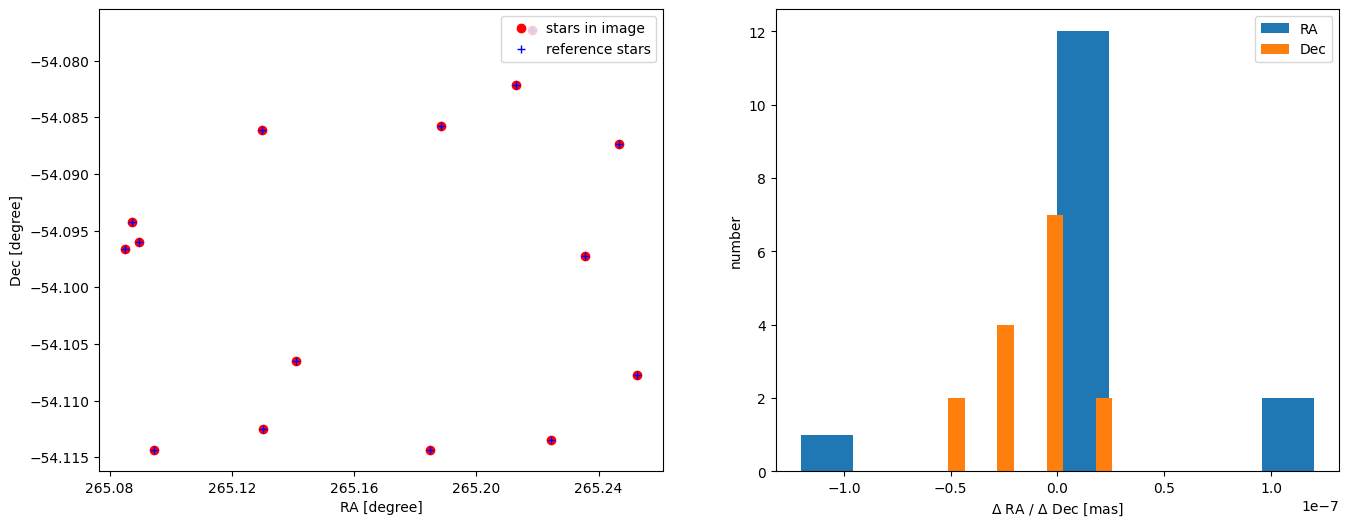

In [61]:
# fig, axes = plt.subplots(1, 3, figsize= (16, 6))

# axes[0].plot(match_radec[0], match_radec[1], '.', c='red')
# axes[1].plot(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, '.', c='blue')

# axes[2].plot(match_radec[0], match_radec[1], '.', c='red')
# axes[2].plot(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, '.', c='blue')

fig, axes = plt.subplots(1, 2, figsize= (16, 6))
from matplotlib.ticker import MaxNLocator
# axes[0].plot(match_radec[0], match_radec[1], '.', c='red')
# axes[1].plot(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, '.', c='blue')

axes[0].plot(match_radec[0], match_radec[1], 'o', c='red', label="stars in image")
axes[0].plot(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, '+', c='blue', label="reference stars")
axes[0].set_ylabel("Dec [degree]")
axes[0].set_xlabel("RA [degree]")
axes[0].xaxis.set_major_locator(MaxNLocator(5))
axes[0].legend(loc=1)


axes[1].hist((match_radec[0] - match_res_ra_gaia_uniqe) * 3600000 * np.mean(np.cos(match_res_dec_gaia_uniqe / 180 * np.pi)), label="RA", bins=10, rwidth=1)
axes[1].hist((match_radec[1] - match_res_dec_gaia_uniqe) * 3600000, label="Dec", bins=10, rwidth=1)
axes[1].set_xlabel(r"$\Delta$ RA / $\Delta$ Dec [mas]")
axes[1].set_ylabel("number")
axes[1].legend(loc=1)

### 更新底片模型

In [62]:
# 全体星应用
sext_out_x = sext_out_filter[:]["XWIN_IMAGE"]
sext_out_y = sext_out_filter[:]["YWIN_IMAGE"]
sext_out_mag_bp = sext_out_filter[:][f"mag_{band}"]
sext_out_mag_auto = sext_out_filter[:]["MAG_AUTO"]

sext_out_xieta = use_plate_model(sext_out_x - x_ref, sext_out_y - y_ref, A_CD_PRE, cof)
sext_out_radec = ideal_cel_coord(sext_out_xieta[0], sext_out_xieta[1], pointing_ra, pointing_dec)

sext_out_ra = sext_out_radec[0]
sext_out_dec = sext_out_radec[1]

# 全体再次匹配
refcat_lib_all = pd.DataFrame({"RA_ICRS": refcat_ra_now, "DE_ICRS": refcat_dec_now})
side_threshold = 0.0001
match_res_all = []

for i in range(len(sext_out_ra)):
    temp_lib = np.array([sext_out_ra[i], sext_out_dec[i]])
    index = np.sum(np.abs(refcat_lib_all - temp_lib) < side_threshold, axis=1) ==2
    if np.sum(index) == 1:
        match_res_all.append(np.hstack((np.array(temp_lib), int(i), np.array(refcat_lib_all[index].loc[:, :"DE_ICRS"])[0])))

match_res_all = np.array(match_res_all)

# 更新底片模型及
match_res_xi_gaia_all, match_res_eta_gaia_all = cel_ideal_coord(match_res_all[:, 3], match_res_all[:, 4], pointing_ra, pointing_dec)
Y_xi = match_res_xi_gaia_all / (np.pi / 180)
Y_eta = match_res_eta_gaia_all / (np.pi / 180)

match_res_x_sext_all = np.zeros_like(match_res_xi_gaia_all)
match_res_y_sext_all = np.zeros_like(match_res_xi_gaia_all)
match_res_mag_bp_all = np.zeros_like(match_res_xi_gaia_all)
match_res_mag_auto_all = np.zeros_like(match_res_xi_gaia_all)
for index, i in enumerate(match_res_all[:, 2]):
    match_res_x_sext_all[index] = sext_out_x[int(i)]
    match_res_y_sext_all[index] = sext_out_y[int(i)]
    match_res_mag_bp_all[index] = sext_out_mag_bp[int(i)]
    match_res_mag_auto_all[index] = sext_out_mag_auto[int(i)]

match_x = match_res_x_sext_all
match_y = match_res_y_sext_all
match_mag_bp = match_res_mag_bp_all
match_mag_auto = match_res_mag_auto_all

print("the matched stars", len(match_x))

cof = min(int(np.floor((np.sqrt(8 * len(match_x) + 1) - 3) / 2)), 4)
cof = 4
cof_mag = 4
# A_CD = cal_plate_model_mag(match_x - x_ref, match_y - y_ref, match_mag_bp, Y_xi, Y_eta, cof, cof_mag)
A_CD = cal_plate_model(match_x - x_ref, match_y - y_ref, Y_xi, Y_eta, cof)
# A_CD = cal_plate_model_(match_x - x_ref, match_y - y_ref, match_mag_bp, Y_xi, Y_eta)
print(A_CD)

# 再应用底片模型
# match_xieta = use_plate_model_mag(match_x - x_ref, match_y - y_ref, match_mag_bp, A_CD, cof, cof_mag)
match_xieta = use_plate_model(match_x - x_ref, match_y - y_ref, A_CD, cof)
# match_xieta = use_plate_model_(match_x - x_ref, match_y - y_ref, match_mag_bp, A_CD)
match_radec = ideal_cel_coord(match_xieta[0], match_xieta[1], pointing_ra, pointing_dec)
gaia_radec = (match_res_all[:, 3], match_res_all[:, 4])
gaia_xieta = cel_ideal_coord(gaia_radec[0], gaia_radec[1], pointing_ra, pointing_dec)


# 残差
dis_xi = (match_xieta[0] - gaia_xieta[0])
dis_eta = (match_xieta[1] - gaia_xieta[1])
dis_ra = (match_radec[0] - match_res_all[:, 3]) * 3600000
dis_dec = (match_radec[1] - match_res_all[:, 4]) * 3600000

# plt.plot(match_x, match_y, '.')

the matched stars 559
[[-8.49502364e-06  1.38912712e-05 -8.59161183e-09  1.42828419e-12
   1.44949298e-11 -1.21874489e-11 -7.75276168e-16  3.11207197e-16
  -7.12187880e-16  2.12861813e-15 -1.06553499e-20  6.23575938e-20
   4.02422109e-19  3.63780661e-18  4.90426502e-18]
 [ 8.88241117e-06  6.33617683e-09 -1.38932466e-05 -1.33375198e-11
   9.19084508e-12 -1.48623057e-11  1.00617448e-17  3.52431935e-16
  -4.43807248e-16 -2.65311516e-15  1.89676119e-20 -9.32729832e-20
  -6.99643409e-19 -6.38501328e-18 -8.63335298e-18]]


In [63]:
match_res_pickle = pd.DataFrame({"X_IMAGE": match_x, "Y_IMAGE": match_y, "DIS_RA": dis_ra, "DIS_DEC": dis_dec, "MAG_BP": match_mag_bp, "MAG_AUTO": match_mag_auto})

with open(f'match_res/match_{band}_{unkonw_index}_res.pkl', 'wb') as f:
    pickle.dump(match_res_pickle, f)

### 残差图

In [74]:
# create bins
bins_num = 1
bins_x = np.linspace(0.5, 9216.5, bins_num + 1)
bins_y = np.linspace(0.5, 9232.5, bins_num + 1)

# bins' centers of all box
bin_centers_x = (bins_x[:-1] + bins_x[1:]) / 2
bin_centers_y = (bins_y[:-1] + bins_y[1:]) / 2
bin_centers = np.transpose([np.tile(bin_centers_x, len(bin_centers_y)), np.repeat(bin_centers_y, len(bin_centers_x))])

# calculate error
distort_sum_bins = np.zeros((bins_num, bins_num))
distort_sum_values_x = np.zeros((bins_num, bins_num))
distort_sum_values_y = np.zeros((bins_num, bins_num))

dis_res_xy = [np.vstack((match_x, match_y, dis_xi, dis_eta))]
[distort_sum_bins, distort_sum_values_x, distort_sum_values_y] = cal_distort_model(dis_res_xy, bins_x, bins_y, bins_num, distort_sum_bins, distort_sum_values_x, distort_sum_values_y)

distort_mean_values_x = np.divide(distort_sum_values_x, distort_sum_bins, out=np.zeros_like(distort_sum_values_x), where=distort_sum_bins != 0)
distort_mean_values_y = np.divide(distort_sum_values_y, distort_sum_bins, out=np.zeros_like(distort_sum_values_y), where=distort_sum_bins != 0)

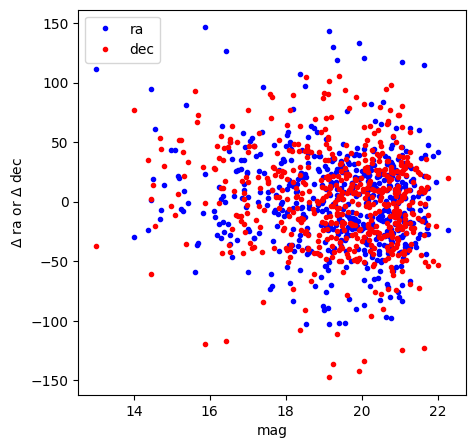

In [75]:
# mag-distortion
bins_x_id, bins_y_id = match_box_id(match_x, match_y, bins_x, bins_y)

dict_mag_dis = {}
fig, axes = plt.subplots(bins_num, bins_num, figsize= (bins_num * 5, bins_num * 5))

for i in range(0, bins_num):
    for j in range(0, bins_num):

        # 各个区域画图
        dict_mag_dis.update({str(i)+str(j): []})
        index = (bins_x_id == i) & (bins_y_id == j)
        match_mag_box = match_mag_bp[index]
        match_x_box = match_x[index]
        match_y_box = match_y[index]
        dis_ra_box = dis_ra[index]
        dis_dec_box = dis_dec[index]
        dis_ra_box, match_mag_ra_box = sigma_filter(dis_ra_box, match_mag_box, 3)
        dis_dec_box, match_mag_dec_box = sigma_filter(dis_dec_box, match_mag_box, 3)

        axe = axes if bins_num == 1 else axes[i][j]
        axe.plot(match_mag_ra_box, dis_ra_box, '.', c='blue', label="ra")
        axe.plot(match_mag_dec_box, dis_dec_box, '.', c='red', label="dec")
        axe.set_xlabel("mag")
        axe.set_ylabel(r"$\Delta$ ra or $\Delta$ dec")
        axe.legend()

        # 
        # bins_num_mag_box = 8
        # bins_mag_box = np.linspace(np.min(match_mag_box) * 0.99, max(match_mag_box) * 1.01, bins_num_mag_box + 1)
        # bin_centers_mag_box = (bins_mag_box[:-1] + bins_mag_box[1:]) / 2
        # dict_mag_dis[str(i)+str(j)].append(bin_centers_mag_box)

        # bins_mag_box_dis = []
        # bins_mag_box_id = np.digitize(match_mag_box, bins_mag_box) - 1
        # for k in range(0, bins_num_mag_box):
        #     index_mag = bins_mag_box_id == k
        #     bins_mag_box_dis.append(np.std(dis_box[index_mag]))
        # dict_mag_dis[str(i)+str(j)].append(bins_mag_box_dis)
            


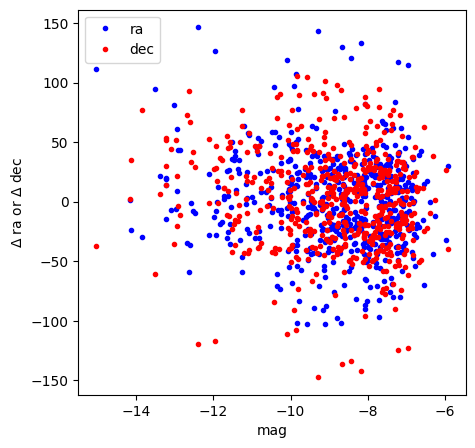

In [76]:
fig, axes = plt.subplots(bins_num, bins_num, figsize= (bins_num * 5, bins_num * 5))

for i in range(0, bins_num):
    for j in range(0, bins_num):

        # 各个区域画图
        dict_mag_dis.update({str(i)+str(j): []})
        index = (bins_x_id == i) & (bins_y_id == j)
        match_mag_box = match_mag_auto[index]
        match_x_box = match_x[index]
        match_y_box = match_y[index]
        dis_ra_box = dis_ra[index]
        dis_dec_box = dis_dec[index]
        dis_ra_box, match_mag_ra_box = sigma_filter(dis_ra_box, match_mag_box, 3)
        dis_dec_box, match_mag_dec_box = sigma_filter(dis_dec_box, match_mag_box, 3)

        index_ra = match_mag_ra_box < -5
        index_dec = match_mag_dec_box < -5

        axe = axes if bins_num == 1 else axes[i][j]
        axe.plot(match_mag_ra_box[index_ra], dis_ra_box[index_ra], '.', c='blue', label="ra")
        axe.plot(match_mag_dec_box[index_dec], dis_dec_box[index_dec], '.', c='red', label="dec")
        axe.set_xlabel("mag")
        axe.set_ylabel(r"$\Delta$ ra or $\Delta$ dec")
        axe.legend()

In [77]:
# fig, axes = plt.subplots(bins_num, bins_num, figsize= (bins_num * 4, bins_num * 4))

# for i in range(0, bins_num):
#     for j in range(0, bins_num):
#         axes[i][j].plot(dict_mag_dis[str(i)+str(j)][0], dict_mag_dis[str(i)+str(j)][1], '.')
#         axes[i][j].set_xlabel("mag")
#         axes[i][j].set_ylabel(r"$\sigma$ dec")


In [78]:
# dict_mag_dis["21"]

# x = dict_mag_dis["21"][0]
# y = dict_mag_dis["21"][1]

# X = np.array([np.ones_like(x), x]).T
# Y = y
# A = np.linalg.inv(X.T @ X) @ X.T @ Y

# plt.plot(dict_mag_dis["21"][0], dict_mag_dis["21"][1], '.')
# plt.plot(dict_mag_dis["21"][0], dict_mag_dis["21"][0] * A[1] + A[0], '.')

### test

In [79]:
# # create bins
# bins_num = 4
# bins_x = np.linspace(0.5, 9216.5, bins_num + 1)
# bins_y = np.linspace(0.5, 9232.5, bins_num + 1)

# # bins' centers of all box
# bin_centers_x = (bins_x[:-1] + bins_x[1:]) / 2
# bin_centers_y = (bins_y[:-1] + bins_y[1:]) / 2
# bin_centers = np.transpose([np.tile(bin_centers_x, len(bin_centers_y)), np.repeat(bin_centers_y, len(bin_centers_x))])

# # calculate distortion error model
# distort_sum_bins = np.zeros((bins_num, bins_num))
# distort_sum_values_x = np.zeros((bins_num, bins_num))
# distort_sum_values_y = np.zeros((bins_num, bins_num))

# dis_res_xy = [np.vstack((match_x, match_y, dis_ra, dis_dec))]
# [distort_sum_bins, distort_sum_values_x, distort_sum_values_y] = cal_distort_model(dis_res_xy, bins_x, bins_y, bins_num, distort_sum_bins, distort_sum_values_x, distort_sum_values_y)

# distort_mean_values_x = np.divide(distort_sum_values_x, distort_sum_bins, out=np.zeros_like(distort_sum_values_x), where=distort_sum_bins != 0)
# distort_mean_values_y = np.divide(distort_sum_values_y, distort_sum_bins, out=np.zeros_like(distort_sum_values_y), where=distort_sum_bins != 0)

# # mag-distortion
# bins_x_id, bins_y_id = match_box_id(match_x, match_y, bins_x, bins_y)

# fig, axes = plt.subplots(bins_num, bins_num, figsize= (bins_num * 4, bins_num * 4))

# for i in range(0, bins_num):
#     for j in range(0, bins_num):
#         index = (bins_x_id == i) & (bins_y_id == j)
#         axes[i][j].plot(match_mag[index] * match_x[index], dis_dec[index], '.')

# ax = plt.matshow(distort_sum_bins)
# plt.colorbar(ax.colorbar, fraction=0.025)

In [80]:
# fig, axes = plt.subplots(1, 2)
# axes[0].quiver(bin_centers[:, 0], bin_centers[:, 1], distort_mean_values_x.flatten(), distort_mean_values_y.flatten(), scale=1500)

# axes[1].matshow(distort_mean_values_x)

# ax = plt.matshow(distort_mean_values_x)
# plt.colorbar(ax.colorbar, fraction=0.025)
# plt.title("matrix X");
# plt.show()